# TreeEnsembleRegressor and parallelisation

The operator [TreeEnsembleRegressor](https://github.com/onnx/onnx/blob/master/docs/Operators-ml.md#ai.onnx.ml.TreeEnsembleRegressor) describe any tree model (decision tree, random forest, gradient boosting). The runtime is usually implements in C/C++ and uses parallelisation. The notebook studies the impact of the parallelisation.

In [1]:
from jyquickhelper import add_notebook_menu
add_notebook_menu()

In [2]:
%matplotlib inline

## Graph

The following graph shows the time ratio between two runtimes depending on the number of observations in a batch (N) and the number of trees in the forest.

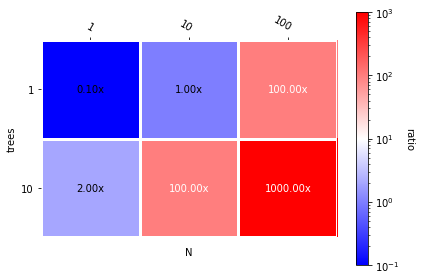

In [3]:
import numpy
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm


def heatmap(data, row_labels, col_labels, ax=None,
            cbar_kw={}, cbarlabel="", **kwargs):
    """
    Create a heatmap from a numpy array and two lists of labels.

    Parameters
    ----------
    data
        A 2D numpy array of shape (N, M).
    row_labels
        A list or array of length N with the labels for the rows.
    col_labels
        A list or array of length M with the labels for the columns.
    ax
        A `matplotlib.axes.Axes` instance to which the heatmap is plotted.  If
        not provided, use current axes or create a new one.  Optional.
    cbar_kw
        A dictionary with arguments to `matplotlib.Figure.colorbar`.  Optional.
    cbarlabel
        The label for the colorbar.  Optional.
    **kwargs
        All other arguments are forwarded to `imshow`.
    """

    if not ax:
        ax = plt.gca()

    # Plot the heatmap
    im = ax.imshow(data, **kwargs)

    # Create colorbar
    cbar = ax.figure.colorbar(im, ax=ax, **cbar_kw)
    cbar.ax.set_ylabel(cbarlabel, rotation=-90, va="bottom")

    # We want to show all ticks...
    ax.set_xticks(numpy.arange(data.shape[1]))
    ax.set_yticks(numpy.arange(data.shape[0]))
    # ... and label them with the respective list entries.
    ax.set_xticklabels(col_labels)
    ax.set_yticklabels(row_labels)

    # Let the horizontal axes labeling appear on top.
    ax.tick_params(top=True, bottom=False,
                   labeltop=True, labelbottom=False)

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=-30, ha="right",
             rotation_mode="anchor")

    # Turn spines off and create white grid.
    for edge, spine in ax.spines.items():
        spine.set_visible(False)

    ax.set_xticks(numpy.arange(data.shape[1]+1)-.5, minor=True)
    ax.set_yticks(numpy.arange(data.shape[0]+1)-.5, minor=True)
    ax.grid(which="minor", color="w", linestyle='-', linewidth=3)
    ax.tick_params(which="minor", bottom=False, left=False)

    return im, cbar


def annotate_heatmap(im, data=None, valfmt="{x:.2f}",
                     textcolors=["black", "white"],
                     threshold=None, **textkw):
    """
    A function to annotate a heatmap.

    Parameters
    ----------
    im
        The AxesImage to be labeled.
    data
        Data used to annotate.  If None, the image's data is used.  Optional.
    valfmt
        The format of the annotations inside the heatmap.  This should either
        use the string format method, e.g. "$ {x:.2f}", or be a
        `matplotlib.ticker.Formatter`.  Optional.
    textcolors
        A list or array of two color specifications.  The first is used for
        values below a threshold, the second for those above.  Optional.
    threshold
        Value in data units according to which the colors from textcolors are
        applied.  If None (the default) uses the middle of the colormap as
        separation.  Optional.
    **kwargs
        All other arguments are forwarded to each call to `text` used to create
        the text labels.
    """

    if not isinstance(data, (list, numpy.ndarray)):
        data = im.get_array()

    # Normalize the threshold to the images color range.
    if threshold is not None:
        threshold = im.norm(threshold)
    else:
        threshold = im.norm(data.max())/2.

    kw = dict(horizontalalignment="center",
              verticalalignment="center")
    kw.update(textkw)

    # Get the formatter in case a string is supplied
    if isinstance(valfmt, str):
        valfmt = matplotlib.ticker.StrMethodFormatter(valfmt)

    texts = []
    for i in range(data.shape[0]):
        for j in range(data.shape[1]):
            kw.update(color=textcolors[int(im.norm(data[i, j]) > threshold)])
            text = im.axes.text(j, i, valfmt(data[i, j], None), **kw)
            texts.append(text)

    return texts

def plot_metric(metric, ax, xlabel="N", ylabel="trees"):
    x = numpy.array(list(sorted(set(k[0] for k in metric))))
    y = numpy.array(list(sorted(set(k[1] for k in metric))))        
    rx = {v: i for i, v in enumerate(x)}
    ry = {v: i for i, v in enumerate(y)}

    X, Y = numpy.meshgrid(x, y)
    zm = numpy.zeros(X.shape, dtype=numpy.float64)
    for k, v in metric.items():
        zm[ry[k[1]], rx[k[0]]] = v

    xs = [str(_) for _ in x]
    ys = [str(_) for _ in y]
    vmin = min(metric.values())
    vmax = max(metric.values())
    im, cbar = heatmap(zm, ys, xs, ax=ax, cmap="bwr", cbarlabel="ratio",
                       norm=LogNorm(vmin=vmin, vmax=vmax))
    texts = annotate_heatmap(im, valfmt="{x:.2f}x")
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)

    
data = {(1, 1): 0.1, (10, 1): 1, (1, 10): 2, (10, 10): 100, (100, 1): 100, (100, 10): 1000}

fig, ax = plt.subplots()
plot_metric(data, ax)
fig.tight_layout();

In [4]:
from tqdm import tqdm

T = list(range(0, 100000))
for nt in tqdm(T):
    numpy.zeros((150, 50))

100%|██████████| 100000/100000 [00:00<00:00, 164392.90it/s]
